In [16]:
# запускаем в colab или локально?
try:
    from google.colab import drive
    colab = True
except ImportError:
    colab = False

print(f"colab: {colab}")

colab: False


In [18]:
# установка необходимых пакетов в colab
if colab:
    ! pip install rootutils -q
    ! pip install torchmetrics -q
    ! pip install torchinfo -q
    ! pip install lightning -q

In [19]:
# монтирование google диска и установка
# рабочей директории в `computer-vision`

import os
import rootutils

root = rootutils.setup_root(".", indicator="homeworks", pythonpath=True)

if colab:
    drive.mount("/content/drive", force_remount=True)
    os.chdir("drive/MyDrive/computer-vision")
else:
    os.chdir(root)

print(f"working directory: {os.getcwd()}")

working directory: /Users/alex/computer-vision


In [20]:
# создание директории для данных

from pathlib import Path

if colab:
    DATA_DIR = Path("/content/data")
else:
    DATA_DIR = root / "data"

DATA_DIR.mkdir(exist_ok=True)

print(f"DATA_DIR: {DATA_DIR}")

DATA_DIR: /Users/alex/computer-vision/data


In [21]:
# настройки для matplotlib

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format="retina"

plt.style.use("seaborn-v0_8-notebook")

## **Полносвязные нейронные сети. Методы регуляризации**

### **Полносвязные нейронные сети**

**Полносвязные нейронные сети** (Fully Connected Neural Networks, FCNN).

Другое название - **многослойный перцептрон** (Multilayer Perceptron, MLP).

#### **Пример полносвязной сети**

<center>
    <figure>
        <img src="figs/02/fcnn.jpg" width="600px"/>
    </figure>
</center>

- У этой сети один входной слой, один выходной слой и три скрытых слоя.

- Параметры нейронной сети 
    $$
        \mathbf{w} = \left\{
            \boldsymbol{\beta}_0,\boldsymbol{\Omega}_0,
            \boldsymbol{\beta}_1,\boldsymbol{\Omega}_1,
            \boldsymbol{\beta}_2,\boldsymbol{\Omega}_2,
            \boldsymbol{\beta}_3,\boldsymbol{\Omega}_3
        \right\}
    $$
    Число параметров равно:
    $$
        (D_1\cdot D_i + D_1) + (D_2\cdot D_1 + D_2) + (D_3\cdot D_2 + D_3) + (D_0\cdot D_3 + D_0) = 43
    $$

- Вычисления слоев нейронной сети:
    $$
        \mathbf{h}_1 = \mathbf{a}\left[\boldsymbol{\beta}_0 + \mathbf{\Omega}_0 \mathbf{x}\right]
    $$
    $$
        \mathbf{h}_2 = \mathbf{a}\left[\boldsymbol{\beta}_1 + \mathbf{\Omega}_1 \mathbf{h}_1\right]
    $$
    $$
        \mathbf{h}_3 = \mathbf{a}\left[\boldsymbol{\beta}_2 + \mathbf{\Omega}_2 \mathbf{h}_2\right]
    $$
    $$
        \mathbf{y} = \boldsymbol{\beta}_3 + \mathbf{\Omega}_3 \mathbf{h}_3
    $$

    где $\mathbf{a}$ - функция активации, обычно это $\mathrm{ReLU}$ (Rectified Linear Unit):
    <center>
        <figure>
            <img src="figs/02/relu.png" width="200px"/>
        </figure>
    </center>

    $$
        a[z] = \mathrm{ReLU}[z] =
        \begin{cases}
            0 & z < 0\\
            z & z \geqslant 0
        \end{cases}
    $$

- Сеть называется **полносвязной**, поскольку каждый элемент (node) связан со всеми предыдущими элементами.


#### **Полносвязные нейронной сети в PyTorch**

Напишем класс для нашей полносвязной нейронной сети в PyTorch:

In [23]:
from torch import nn

class Net(nn.Module):
    def __init__(self, Di=3, D1=4, D2=2, D3=3, Do=2):
        super().__init__()

        self.lin1 = nn.Linear(Di, D1)
        self.lin2 = nn.Linear(D1, D2)
        self.lin3 = nn.Linear(D2, D3)
        self.lin4 = nn.Linear(D3, Do)

        self.act = nn.ReLU() 
         
    def forward(self, x):
        h1 = self.act(self.lin1(x))
        h2 = self.act(self.lin2(h1))
        h3 = self.act(self.lin3(h2))
        
        y = self.lin4(h3)

        return y

Протестируем работу сети:

In [24]:
import torch

# модель сети
model = Net()

# батч размера 5 из случайных чисел
x = torch.rand((5, 3))

# forward pass
y = model(x)

print(f"x.shape: {x.shape}")
print(f"\nx: {x}")
print(f"\ny.shape: {y.shape}")
print(f"\ny: {y}")

x.shape: torch.Size([5, 3])

x: tensor([[0.4963, 0.6110, 0.3511],
        [0.7422, 0.2820, 0.5964],
        [0.4928, 0.4250, 0.7450],
        [0.1069, 0.0778, 0.2699],
        [0.7057, 0.7139, 0.4999]])

y.shape: torch.Size([5, 2])

y: tensor([[-0.8796,  0.0899],
        [-0.8828,  0.0907],
        [-0.9017,  0.0812],
        [-0.8735,  0.0977],
        [-0.8852,  0.0877]], grad_fn=<AddmmBackward0>)


Выведем информацию о архитектуре сети:

In [25]:
import torchinfo

print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5, 2]                    --
├─Linear: 1-1                            [5, 4]                    16
├─ReLU: 1-2                              [5, 4]                    --
├─Linear: 1-3                            [5, 2]                    10
├─ReLU: 1-4                              [5, 2]                    --
├─Linear: 1-5                            [5, 3]                    9
├─ReLU: 1-6                              [5, 3]                    --
├─Linear: 1-7                            [5, 2]                    8
Total params: 43
Trainable params: 43
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Можно написать более компактную реализацию с помощью `torch.nn.Sequential`:

In [28]:
class Net(nn.Module):
    def __init__(self, Di=3, D1=4, D2=2, D3=3, Do=2):
        super().__init__()

        act = nn.ReLU()

        self.layers = nn.Sequential(
            nn.Linear(Di, D1),
            act,
            nn.Linear(D1, D2),
            act,
            nn.Linear(D2, D3),
            act,
            nn.Linear(D3, Do),
        )
         
    def forward(self, x):
        y = self.layers(x)

        return y
    
    model = Net()

    print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5, 2]                    --
├─Sequential: 1-1                        [5, 2]                    --
│    └─Linear: 2-1                       [5, 4]                    16
│    └─ReLU: 2-2                         [5, 4]                    --
│    └─Linear: 2-3                       [5, 2]                    10
│    └─ReLU: 2-4                         [5, 2]                    --
│    └─Linear: 2-5                       [5, 3]                    9
│    └─ReLU: 2-6                         [5, 3]                    --
│    └─Linear: 2-7                       [5, 2]                    8
Total params: 43
Trainable params: 43
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


### **Классификация изображений Fashion-MNIST**

<center>
        <figure>
            <img src="figs/02/fashion_mnist.jpg" width="600px"/>
        </figure>
    </center>
Обучим полносвязную нейронную сеть классифицировать изображения из датасета Fashion-MNIST:

- Размер изображений: 28x28 пикселей

- Цветовое пространство: grayscale

- Количество классов: 10 (одежда)

- Размер набора данных: 60 000 обучающих и 10 000 тестовых изображений


В torchvision есть класс `torchvision.datasets.FashionMNIST` для работы с этим датасетом:

In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms as T

import numpy as np

# 1. Define transformations: Convert images to PyTorch tensors
transform = T.Compose([
    T.ToTensor()
])
             
# 2. Load the Fashion-MNIST datasets (downloads if not present)
train_dataset = FashionMNIST(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = FashionMNIST(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform
)

# 3. Define the class names
class_names = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


Посмотрим на один из сэмплов:

In [ ]:
# x - tensor
# y - int
x, y = train_dataset[2026]

class_name = class_names[y]

print(f"x.shape: {x.shape}")
print(f"label: {y}")
print(f"class name: {class_name}")

x.shape: torch.Size([1, 28, 28])
label: 3
class name: Dress


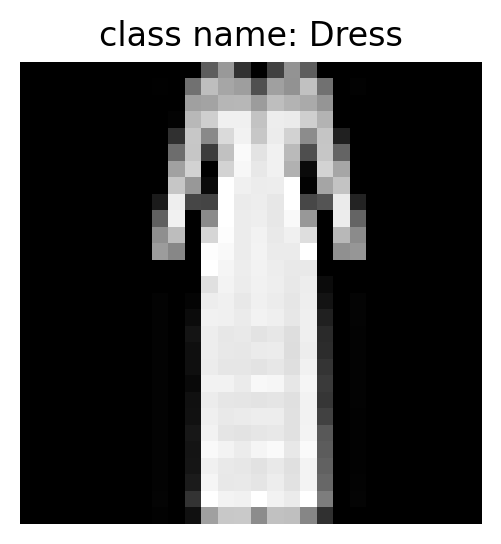

In [44]:
import matplotlib.pyplot as plt

# де-нормализация изображения
image = (255 * x.squeeze()).numpy().astype(np.uint8)

# построение изображения
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"class name: {class_name}")
plt.axis("off");

Мы напишем собственную реализацию `torch.utils.data.Dataset` для Fashion-MNIST.

Загрузим и распакуем изображения с google диска:

In [45]:
from src.utils import download_and_extract

download_and_extract("1KpBql_Rpc1dtBSwFTT7UZdNLUoDde6YQ", "fashion-mnist.zip", DATA_DIR)

/Users/alex/computer-vision/data/fashion-mnist.zip downloading...
Extracting...
Done!


Напишем класс для итерации по данным по одному сэмплу (x, y):

- x - изображение 28 x 28

- y - метка класса 0, 1, 2, ..., 9

In [49]:
import cv2
import numpy as np
from pathlib import Path

from torch.utils.data import Dataset

class DataSet(Dataset):
    def __init__(self, data_dir):
        super().__init__()

        self.files = list(Path(data_dir).glob("**/*.png"))
        self.labels = [int(f.parent.name) for f in self.files]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = cv2.imread(self.files[index], cv2.IMREAD_GRAYSCALE)

        # нормализация изображения в диапазон [0, 1]
        x = image.astype(np.float32) / 255

        # преобразование размера
        # 28 x 28 в 1 x 28 x 28
        x = x[None]

        # метка класса 
        y = self.labels[index]

        return x, y

Создадим датасеты для обучения и тестирования:

In [50]:
dataset = DataSet(DATA_DIR / "fashion-mnist/train")
test_dataset = DataSet(DATA_DIR / "fashion-mnist/test")

# число изображений в датасетах
print(f"dataset size: {len(dataset)}")
print(f"test_dataset size: {len(test_dataset)}")

dataset size: 60000
test_dataset size: 10000


Посмотрим на один из сэмплов:

x shape: (1, 28, 28)
y: 9


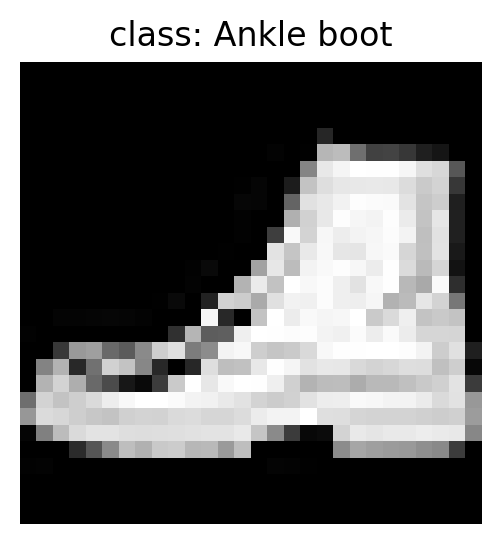

In [52]:
# x - numpy массив
# y - int
x, y = dataset[2026]

# имя класса
class_name = class_names[y]

print(f"x shape: {x.shape}")
print(f"y: {y}")

# де-нормализация изображения
image = (255 * x[0]).astype(np.uint8)

# построение изображения
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")
plt.title(f"class: {class_name}")
plt.axis("off");

Разделим `dataset` на датасеты для обучения и валидации:

In [53]:
from torch.utils.data import random_split

train_dataset, valid_dataset = random_split(
    dataset,
    [50_000, 10_000]
)

print(f"train_dataset size: {len(train_dataset)}")
print(f"valid_dataset size: {len(valid_dataset)}")

train_dataset size: 50000
valid_dataset size: 10000


Создадим загрузчики батчей для обучения и валидации:

In [54]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,   # датасет
    batch_size=1024, # размер батча
    num_workers=0,   # число процессов для формирования батчей
    shuffle=True,    # перемешивать датасет в конце каждой эпохи
    drop_last=True   # выбрасывать последний неполный батч в эпохе
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=1024,
    num_workers=0,
    shuffle=False,
    drop_last=False
)

# число батчей
print(f"train_loader size: {len(train_loader)}")
print(f"valid_loader size: {len(valid_loader)}")

train_loader size: 48
valid_loader size: 10


Сгенерируем один батч из данных для обучения: 

In [56]:
# для изображений размер батча должен
# иметь вид B x C x H x W
# (размер батча) x (число цветовых каналов) x (высота изображения) x (ширина изображения)

# выборка случайного батча данных из датасета
# x, y - это тензоры
x, y = next(iter(train_loader))

# приведение к нужному типу данных
x = x.float()
y = y.long()

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}\n")

print(f"x.min(): {x.min()}")
print(f"x.max(): {x.max()}")

x shape: torch.Size([1024, 1, 28, 28])
y shape: torch.Size([1024])

x.min(): 0.0
x.max(): 1.0


Создадим полносвязную нейронную сеть для классификации с двумя скрытыми слоями:

In [66]:
class Classification(nn.Module):
    def __init__(self, Di=28*28, D1=392, D2=196, D3=98, Do=10):
        super().__init__()

        act = nn.ReLU()

        self.layers = nn.Sequential(
            nn.Linear(Di, D1),
            act,
            nn.Linear(D1, D2),
            act,
            nn.Linear(D2, D3),
            act,
            nn.Linear(D3, Do),
        )

    def forward(self, x):
        # преобразуем размер 
        # B x 1 x 28 x 28 -> B x (28 * 28)
        x = x.view(-1, 28 * 28)
        
        y = self.layers(x)

        return y

Протестируем модель сети:

In [71]:
model = Classification()

x, y = next(iter(valid_loader))

y_hat = model(x)

print(f"x shape: {x.shape}")
print(f"y_hat shape: {y_hat.shape}")

x shape: torch.Size([1024, 1, 28, 28])
y_hat shape: torch.Size([1024, 10])


Выведем архитектуру модели:

In [70]:
print(torchinfo.summary(model, input_size=x.shape, device="cpu"))

Layer (type:depth-idx)                   Output Shape              Param #
Classification                           [1024, 10]                --
├─Sequential: 1-1                        [1024, 10]                --
│    └─Linear: 2-1                       [1024, 392]               307,720
│    └─ReLU: 2-2                         [1024, 392]               --
│    └─Linear: 2-3                       [1024, 196]               77,028
│    └─ReLU: 2-4                         [1024, 196]               --
│    └─Linear: 2-5                       [1024, 98]                19,306
│    └─ReLU: 2-6                         [1024, 98]                --
│    └─Linear: 2-7                       [1024, 10]                990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 414.77
Input size (MB): 3.21
Forward/backward pass size (MB): 5.70
Params size (MB): 1.62
Estimated Total Size (MB): 10.53


Функция потерь для задачи мультиклассовой классификации - средняя кросс-энтропия на батче (Cross Entropy):
$$
    \mathbf{CE} = 
    -\frac{1}{|\mathcal{I}_t|}
    \sum_{i\in\mathcal{I}_t}\mathbf{p}_i\cdot\ln \widehat{\mathbf{p}}_i
$$
где $\mathbf{p}_i$ - one-hot вектор истинных вероятностей изображения с номером $i$:
$$
   \mathbf{p}_i = (0\,,0\,,\ldots\,,1\,,0\,,\ldots\,,0)
$$ 
$\widehat{\mathbf{p}}_i$ - вектор предсказанных моделью вероятностей изображения с номером $i$:
$$
    \widehat{\mathbf{p}}_i = \mathrm{softmax}[\widehat{\mathbf{y}}_i] = 
    \frac{\exp[\widehat{\mathbf{y}}_i]}{\sum\limits_j \exp[\widehat{y}_{ij}]}
$$

Загрузчик данных возвращает $\left\{\mathbf{y}_i\right\}_{i\in\mathcal{I}_t}$.

Модель возвращает $\left\{\widehat{\mathbf{y}}_i\right\}_{i\in\mathcal{I}_t}$.

Все необходимые преобразования в вероятности происходят в классе `torch.nn.CrossEntropyLoss()`:

In [72]:
loss_fn = nn.CrossEntropyLoss()

x, y = next(iter(train_loader))

y_hat = model(x.float())

# вычисление loss функции по предсказанию `y_hat` и реальному `y`
# вычисления softmax и one-hot encoding `y` реализовано в `loss_fn` 
loss = loss_fn(y_hat, y)

print(f"loss value = {loss}")

loss value = 2.308345079421997
